In [23]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
from cv2 import cv2 as cv
import random 
import argparse
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

Definition der Datensatz Klasse, diese stellt Bilder + Annotationen zum training bereit. Die Bilder werden dabei zur trainingszeit zusammen gesetzt sodass eine Explizite größen angabe erfolgen muss.

In [24]:
class fake_dataset(Dataset):
    def __init__(self, sign_path: str, background_path: str, length: int, 
                 scr: tuple[int, int], img_sice: tuple[int, int], sign_sice: tuple[int, int], transforms = None):
        self.sign_path = sign_path
        self.background_path = background_path
        self.signs = os.listdir(sign_path)
        self.backgrounds = os.listdir(background_path)
        self.length = length
        self.scr = scr
        self.sign_size = sign_sice
        self.transforms = transforms
    def get_rand_img(root, paths) -> np.ndarray:
        path = paths[random.randrange(0, len(paths))]
        img = cv.imread(os.path.join(root, path), cv.IMREAD_UNCHANGED)
        if (img.shape[2] == 3):
            img = img[:,:,[2, 1, 0]]
        elif (img.shape[2] == 4):
            img = img[:,:,[2, 1, 0, 3]]
        else:
            assert False
        return img
    def __len__(self) -> int:
        return self.length
    def __getitem__(self, idx):
        sign_count = random.randrange(self.scr[0], self.scr[1])
        img = fake_dataset.get_rand_img(self.background_path, self.backgrounds)
        boxes = []
        labels = []
        area = []
        for i in range(sign_count):
            sign = fake_dataset.get_rand_img(self.sign_path, self.signs)
            size = random.randrange(self.sign_size[0], self.sign_size[1])
            scaling = size / max(sign.shape)
            sign = cv.resize(sign, dsize=(0, 0), fx=scaling, fy=scaling)
            w = sign.shape[0]
            h = sign.shape[1]
            x = random.randrange(0, img.shape[0] - sign.shape[0])
            y = random.randrange(0, img.shape[1] - sign.shape[1])
            alpha = sign[:,:,3]/255
            alpha = np.stack([alpha, alpha, alpha], axis=-1)
            sign = sign[:,:,0:3] * alpha
            img[x:x+w, y:y+h,:] = img[x:x+w, y:y+h,:] * (1-alpha) + sign
            boxes.append(np.array([x, y, x+w, y+h]))
            labels.append(1)
            area.append(w*h)
        target = {"boxes": torch.tensor(np.stack(boxes), dtype=torch.float32), 
                  "labels": torch.tensor(labels, dtype=torch.int64),
                  "image_id": torch.tensor([idx], dtype=torch.int64),
                  "area": torch.tensor(area, dtype=torch.float32)}
        img = Image.fromarray(img)
        # = np.transpose(img, (2, 0, 1))
        #img = torch.tensor(img, dtype=torch.float32) / 255
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

Testing the Dataset

In [25]:
dataset = fake_dataset("blender/out/imgs", "backgrounds", 10, (3, 7), (1280, 720), (100, 500))

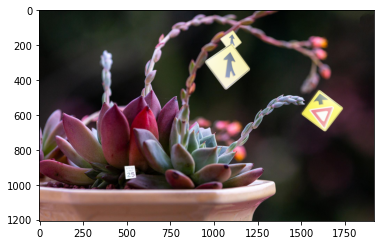

In [26]:
img, target = dataset.__getitem__(0)
plt.figure()
plt.imshow(img)
plt.show()

In [27]:
import detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.Normalize())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Setting up the Model, Dataset and Dataloaders

In [28]:
import detection.utils as utils
device = torch.device("cuda")
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()
model.to(device)
dataset_train = fake_dataset("blender/out/imgs", "backgrounds", 10, (3, 7), (1280, 720), (100, 500), get_transform(True))
dataset_eval = fake_dataset("blender/out/imgs", "backgrounds", 10, (3, 7), (1280, 720), (100, 500), get_transform(False))
train_loader = DataLoader(dataset_train, 4, collate_fn=utils.collate_fn)
eval_loader = DataLoader(dataset_eval, 4, collate_fn=utils.collate_fn)


In [29]:
test_img, test_target = dataset_train.__getitem__(0)
#model([test_img], [test_target])

In [30]:

#@todo Fix Hardcoded params
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
            parameters,
            lr=0.01,
            momentum=1,
            weight_decay=1,
        )

for i in range(100):
    for j, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        result = model(images, targets)
    #with torch.cuda.amp.autocast(enabled=scaler is not None):
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        print(f"Epoch: {i}, {j}/{len(train_loader)}")

Epoch: 0, 0/3
Epoch: 0, 1/3
Epoch: 0, 2/3
Epoch: 1, 0/3
Epoch: 1, 1/3
Epoch: 1, 2/3
Epoch: 2, 0/3
Epoch: 2, 1/3
Epoch: 2, 2/3
Epoch: 3, 0/3
Epoch: 3, 1/3
Epoch: 3, 2/3
Epoch: 4, 0/3
Epoch: 4, 1/3
Epoch: 4, 2/3
Epoch: 5, 0/3
Epoch: 5, 1/3
Epoch: 5, 2/3
Epoch: 6, 0/3
Epoch: 6, 1/3
Epoch: 6, 2/3
Epoch: 7, 0/3
Epoch: 7, 1/3
Epoch: 7, 2/3
Epoch: 8, 0/3
Epoch: 8, 1/3
Epoch: 8, 2/3
Epoch: 9, 0/3
Epoch: 9, 1/3
Epoch: 9, 2/3
Epoch: 10, 0/3
Epoch: 10, 1/3
Epoch: 10, 2/3
Epoch: 11, 0/3
Epoch: 11, 1/3


KeyboardInterrupt: 